## Tumor Image Classifier and Explainer (Testversion)
with pre-trained ResNet50 Model <br>
and three explanation algorithms: IG, GradCAM and LRP
<br>
<br>
##### Note: <br>
This version has been shortened for clarity during evaluation. Additionally, for testing purposes, two input images are always displayed: 1. the saliency map and 2. the original example image for better comparison. In general, two different brain tumors are displayed for each explanation algorithm. <br> The main structure is as follows: <br>
1. Including Packages
2. Load Model and Classify Images
3. Model Explainer <br>
    3.1 IG <br>
        - Example Picture I (Meningioma) <br>
        - Example Picture II (Glioma) <br>
    3.2 GradCAM <br>
        - Example Picture I (Meningioma) <br>
        - Example Picture II (Glioma) <br>
    3.3 LRP <br>
        - Example Picture I (Meningioma) <br>
        - Example Picture II (Glioma) <br>
        

##### Info: <br>
Labels: 0. None, 1. Meningioma, 2. Glioma, 3. Pituitary <br>
GitHub Repository for ResNet50 Model Basis: https://github.com/aksh-ai/neuralBlack

### 1. Including Packages 

In [1]:
import pickle
import cv2
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from PIL import Image
from torchvision import transforms, models
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from matplotlib import colormaps
from torchsummary import summary
import json
from PIL import Image as PilImage
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from omnixai.preprocessing.image import Resize
from omnixai.explainers.vision import IntegratedGradientImage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient

### 2. Load the Model and classify Images

In [2]:
##########################################
### ResNet50 Model Classifier ############
##########################################

from PIL import Image


device_name = "cuda:0:" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

resnet_model = models.resnet50(pretrained=True)

for param in resnet_model.parameters():
    param.requires_grad = True

n_inputs = resnet_model.fc.in_features

resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

for name, child in resnet_model.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

resnet_model.to(device)

resnet_model.load_state_dict(torch.load('/Users/alinatenne/Documents/Masterarbeit/Pre-Trained_Modell_GitHub/neuralBlack-master/models/bt_resnet50_model.pt', map_location=torch.device('cpu')))



resnet_model.eval()

transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])

LABELS = ['None', 'Meningioma', 'Glioma', 'Pitutary']

img_name = input("Enter path to the image: ")

if not os.path.exists(img_name):
    print("File does not exits. Exiting...\n")
    exit()

img = Image.open(img_name)

img = transform(img)

img = img[None, ...]

with torch.no_grad():
    y_hat = resnet_model.forward(img.to(device))

    predicted = torch.argmax(y_hat.data, dim=1)

    print(LABELS[predicted.data],'\n')
    
#### Testing all possible Tumor Types:
# 1. Meningioma (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Meningioma_3064.jpg
# 2. Pituitary (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Pituitary_999.jpg
# 3. Glioma (was detected)
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_3041.jpg

# Example Image I:
# /Users/alinatenne/Downloads/chordoid-meningioma-1.jpg
# Example Image II:
# /Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Enter path to the image: /Users/alinatenne/Downloads/chordoid-meningioma-1.jpg
Meningioma 



#### Example Image I:

This example image contains a Meningioma Tumor (Label 1) and is choosen from an open source tumor collection by Mahomed A. Osman. <br>
The image collection can be found here: https://radiopaedia.org/articles/meningioma. <br>
The image has not been part of the model training and is therefore new to the model.

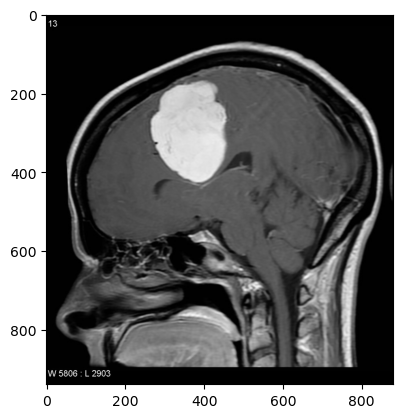

In [3]:
test_img_1 = Image.open('/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg')
test_img_data = np.asarray(test_img_1)
plt.imshow(test_img_data)


#### Example Image II:

This Example Picture contains a Glioma Tumor (Label 2) and is choosen from the testing data set by Jun Cheng. <br> The dataset can be found here: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427. <br>
As this is an image from the test set, this input is not new to the ResNet50 model.

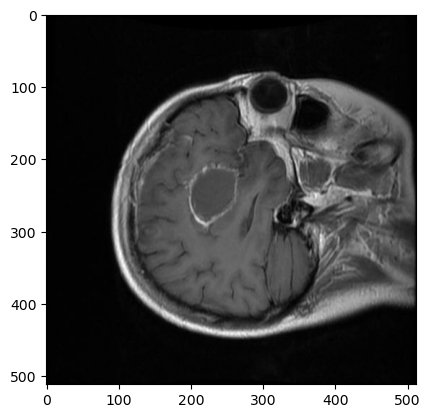

In [4]:
test_img_2 = Image.open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")
test_img_data = np.asarray(test_img_2)
plt.imshow(test_img_data)

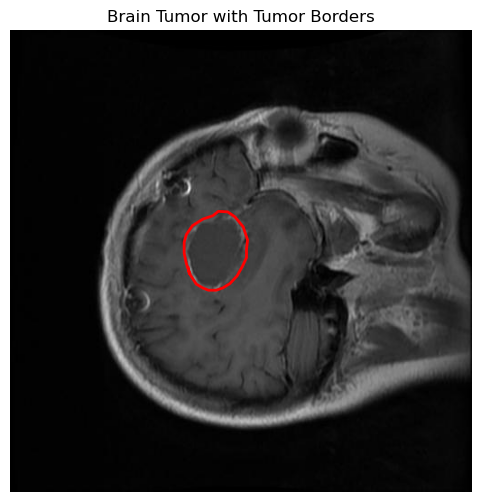

In [5]:
##########################################################################
#### Extracting the Tumor with the Tumor Boardes to visualise Tumor ######
##########################################################################

# Loading the saved pickle list with tumour boundary coordinates
pickle_in = open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/tumor_borders.pickle", "rb")
border_data = pickle.load(pickle_in)

# set Index for Image to be classified (range 0-3064)
image_index = 889

# load tumor coordinates with border_data
tumor_border = np.array(border_data[image_index])  # convert to NumPy-Array
tumor_border = tumor_border.reshape(-1, 2)  # convert to a two-dimensional array

# load Image
image_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/new_dataset/bt_images/{}.jpg".format(image_index + 1)
img = plt.imread(image_path)

# display Image with tumor borders
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.plot(tumor_border[:, 1], tumor_border[:, 0], color='red', linewidth=2)
plt.title('Brain Tumor with Tumor Borders')
plt.axis('off')
plt.show()

### 3. Model Explainer


### 3.1 Integrated Gradients
Source: https://pytorch.org/tutorials/beginner/introyt/captumyt.html
<br> 
##### 3.1.1 Image Preparation

In [6]:
#from PIL import Image
# model expectation is 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224), #crop the given tensor image at the center
 transforms.ToTensor()
])
# ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg')
img_2 = Image.open("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")

transformed_img = transform(img)
transformed_img_2 = transform(img_2)

input = transform_normalize(transformed_img)
#unsqueeze returns a new tensor with a dimension of size one inserted at the #specified position.
input = input.unsqueeze(0)

### same procedure for example image II #####
input_2 = transform_normalize(transformed_img_2)
input_2 = input_2.unsqueeze(0)

In [7]:
################################################
### Check if GPU is available with Pytorch #####
################################################

#import torch
torch.cuda.empty_cache()

# Proove if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
# Force to use CPU
device = torch.device("cpu")

# move model and input data to device (!)
resnet_model.to(device)
input = input.to(device)

### same for different input data ####
input_2 = input_2.to(device)

##### 3.1.2 IG Model Explainer

In [8]:
#######################################
### Get Integrated Gradients Map ######
#######################################

with torch.enable_grad():
    # Perform a forward pass to get predictions
    output = resnet_model(input)

    # Get the predicted label index
    pred_label_idx = torch.argmax(output).item()

# Create Integrated Gradients object and get attributes
integrated_gradients = IntegratedGradients(resnet_model)

# Request the algorithm to assign output target
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

#### Example Image I:

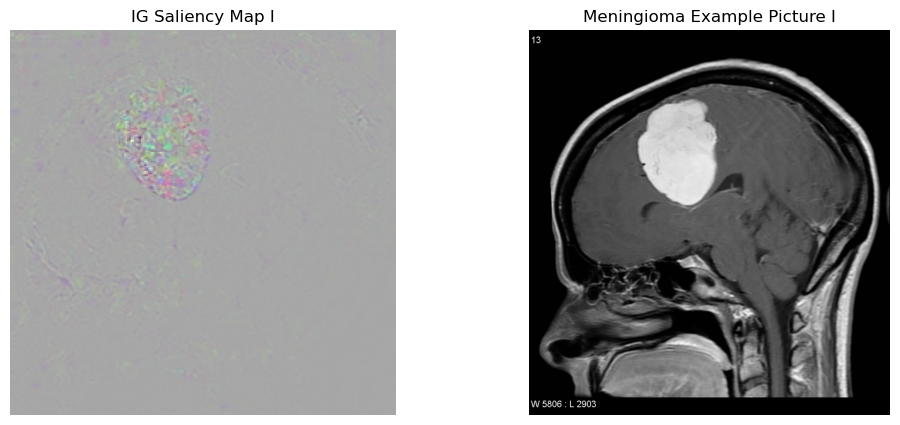

In [9]:
##################################
#### Map/ Display IG Method ######
##################################
heatmap = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
# normalise heatmap to get value range from 0 to 1
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

plt.figure(figsize=(12, 5))  # Adjust the size of the plot

# plot heatmap
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(heatmap, cmap='viridis', alpha=0.8)
plt.title('IG Saliency Map I')
plt.axis('off') 

# plot example picture I
plt.subplot(1, 2, 2)  # One row, two columns, second plot
image_path = '/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg'
image = plt.imread(image_path)
plt.imshow(image)
plt.title('Meningioma Example Picture I')
plt.axis('off')
plt.show()

#### Example Image II:

In [10]:
# Request the algorithm to assign output target
attributions_ig = integrated_gradients.attribute(input_2, target=pred_label_idx, n_steps=200)

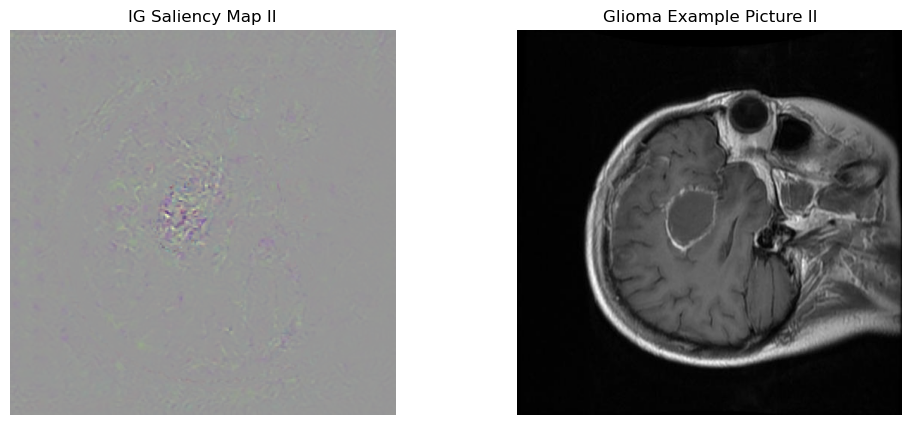

In [11]:
##################################
#### Map/ Display IG Method II ###
##################################

# convert attributes to Numpy-Array and transpose to get correct format
heatmap = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

# normalise heatmap to get value range from 0 to 1
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

###### Heatmap with "Glioma Example Image II" Image Input ########
plt.figure(figsize=(12, 5))  # Adjust the size of the plot

# plot heatmap
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(heatmap, cmap='viridis', alpha=0.8)
plt.title('IG Saliency Map II')
plt.axis('off') 

# plot example picture I
plt.subplot(1, 2, 2)  # One row, two columns, second plot
image_path = "/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg"
image = plt.imread(image_path)
plt.imshow(image)
plt.title('Glioma Example Picture II')
plt.axis('off')
plt.show()

### 3.2 GradCAM
<br>
Source: https://github.com/frgfm/torch-cam

##### 3.2.1 Image Preparation

In [12]:
# Get your input
img = read_image("/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg")
img_2 = read_image("/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg")

# Preprocess input
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

input_tensor_2 = normalize(resize(img_2, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


##### 3.2.2 Model Explainer

In [13]:
model = resnet_model

# choose target layer
target_layer = model.layer1[-1]
#target_layer = model.layer2[-1]
#target_layer = model.layer4[-1]
#target_layer = model.layer4[-1].conv3


cam_extractor = SmoothGradCAMpp(model, target_layer)

#### Example Image I:

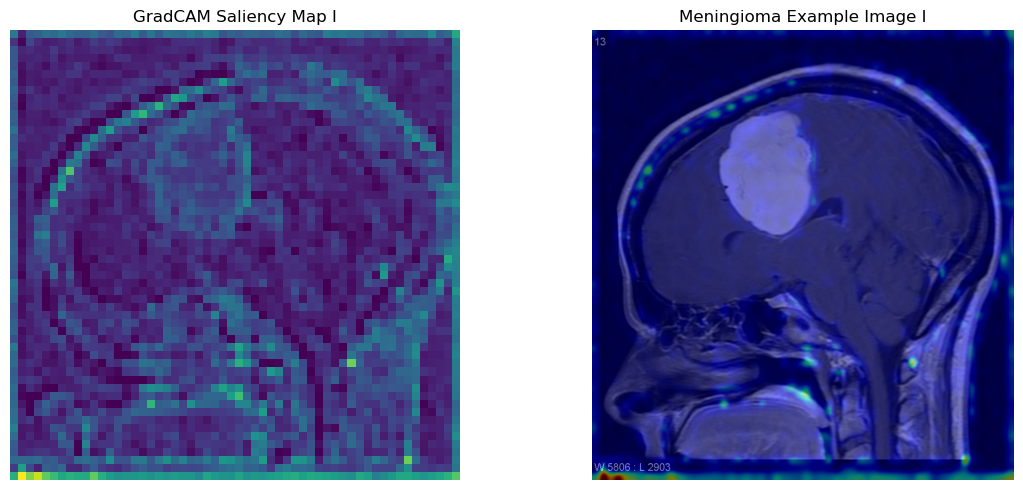

In [14]:
####################################
#### Map/ Display GradCAM Method ###
####################################

out = model(input_tensor.unsqueeze(0))

activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the activation map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.title('GradCAM Saliency Map I')
plt.axis('off')  # Turn off axes

# Plot the overlaid image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(result)
plt.title('Meningioma Example Image I')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

#### Example Image II:

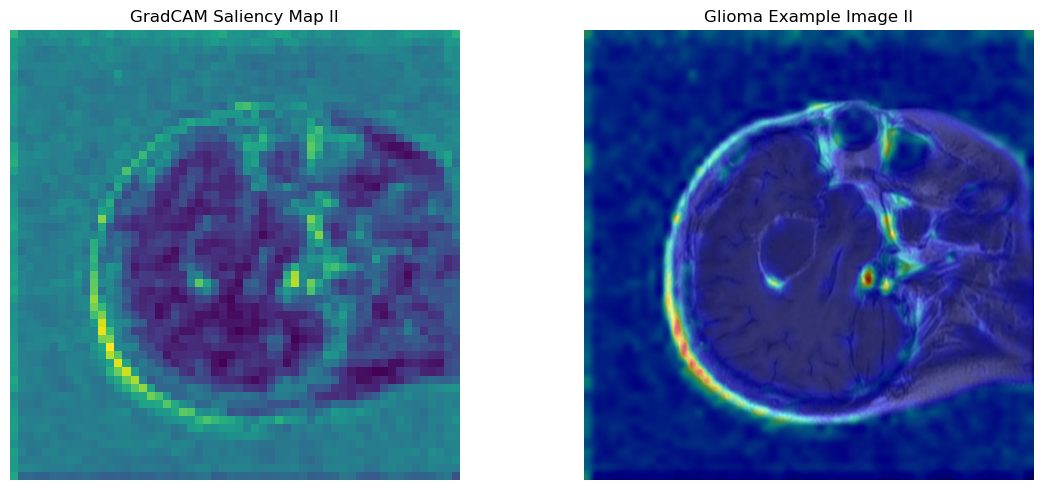

In [15]:
#######################################
#### Map/ Display GradCAM Method II ###
#######################################

out = model(input_tensor_2.unsqueeze(0))

activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img_2), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Display it
# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the activation map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(activation_map[0].squeeze(0).numpy())
plt.title('GradCAM Saliency Map II')
plt.axis('off')  # Turn off axes

# Plot the overlaid image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(result)
plt.title('Glioma Example Image II')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

### 3.3 LRP
<br>
Source: https://github.com/chr5tphr/zennit

##### 3.3.1 Image Preparation

In [16]:
image_path_2 = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg'
image_path = '/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg'
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # add Batch-Dimension

image_2 = Image.open(image_path_2)
image_tensor_2 = transform(image_2).unsqueeze(0)  # add Batch-Dimension

##### 3.3.2 Model Explainer

In [17]:
# Amount of classes (0 to 3) (None, M, P, G)
num_classes = 4

# Canonizers und Composite
canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonGammaBox(low=-3., high=3., canonizers=canonizers)

#### Example Image I:

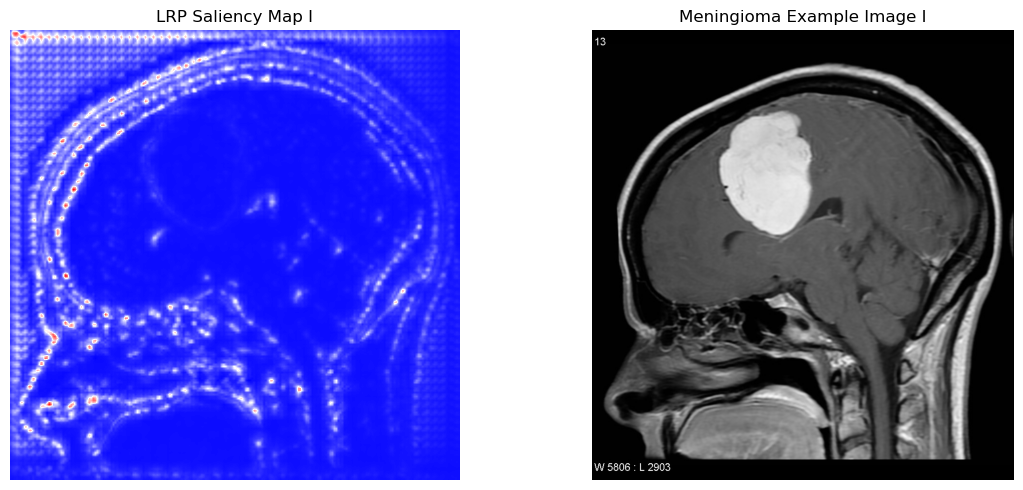

In [18]:
####################################
#### Map/ Display LRP Method #######
####################################

# Attribution with Gradient
with Gradient(model=resnet_model, composite=composite) as attributor:
    out, relevance = attributor(image_tensor, torch.eye(num_classes)[[1]])  # set prediction class (!)

# relevanz map transformed to grey-scaled image
relevance_map = relevance.squeeze().cpu().numpy()  # Relevance map with correct formation
relevance_map = relevance_map.mean(axis=0)  # Mean of color channels
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())  # Normalization to [0, 1]

# Load the comparison image
image_path = '/Users/alinatenne/Downloads/chordoid-meningioma-1.jpg'
comparison_image = plt.imread(image_path)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the relevance map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear') # Blue-white-red color map
plt.title('LRP Saliency Map I')
plt.axis('off')  # Turn off axes

# Plot the comparison image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(comparison_image)
plt.title('Meningioma Example Image I')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()


#### Example Image II:

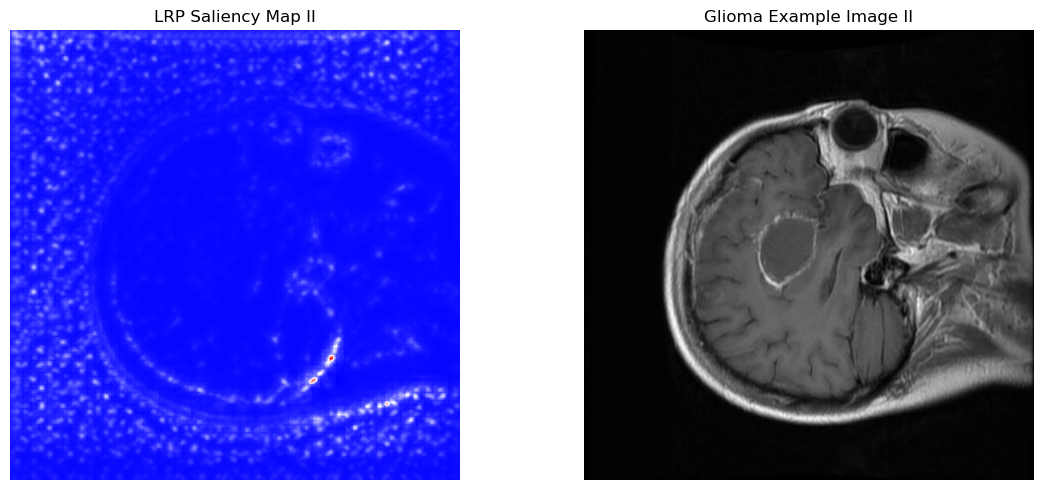

In [19]:
####################################
#### Map/ Display LRP Method II ####
####################################

# Attribution with Gradient
with Gradient(model=resnet_model, composite=composite) as attributor:
    out, relevance = attributor(image_tensor_2, torch.eye(num_classes)[[2]])  # set prediction class (!)

# relevanz map transformed to grey-scaled image
relevance_map = relevance.squeeze().cpu().numpy()  # Relevance map with correct formation
relevance_map = relevance_map.mean(axis=0)  # Mean of color channels
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())  # Normalization to [0, 1]

# Load the comparison image
image_path = '/Users/alinatenne/Documents/Masterarbeit/Brain Tumor Dataset_2017/Test_Images/Glioma_889.jpg'
comparison_image = plt.imread(image_path)

# Plot both images side by side
plt.figure(figsize=(12, 5))  # Adjusting the size of the plot

# Plot the relevance map
plt.subplot(1, 2, 1)  # One row, two columns, first plot
plt.imshow(relevance_map, cmap='bwr', interpolation='bilinear') # Blue-white-red color map
plt.title('LRP Saliency Map II')
plt.axis('off')  # Turn off axes

# Plot the comparison image
plt.subplot(1, 2, 2)  # One row, two columns, second plot
plt.imshow(comparison_image)
plt.title('Glioma Example Image II')
plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()
